In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import geojson
from shapely.geometry import Polygon, LineString
from shapely.ops import split
from shapely.geometry import Point, LineString, Polygon, MultiPoint
from numpy import ones,vstack
from numpy.linalg import lstsq
import pandas as pd
import csv
import openpyxl
from itertools import islice
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay

In [2]:
pixel_size = 0.346
s1_geo = geojson.load(open('../Inputs/404_1_S1.geojson','rb'))
s1_coordinates = np.array(s1_geo["features"][0]["geometry"]["coordinates"][0]) * pixel_size
s1_pixel_coordinates = np.array(s1_geo["features"][0]["geometry"]["coordinates"][0])

In [3]:
def distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

In [4]:
input_file = '../Inputs/404_1_cell_position.txt'
wb = openpyxl.Workbook()
ws = wb.worksheets[0]

with open(input_file, 'r') as data:
    reader = csv.reader(data, delimiter='\t')
    for row in reader:
        ws.append(row) 
data = ws.values
cols = next(data)[1:]
data = list(data)
idx = [r[0] for r in data]
data = (islice(r, 1, None) for r in data)
df_404 = pd.DataFrame(data, index=idx, columns=cols)
cells_centroid_x = df_404['Centroid X µm'].to_numpy(dtype=float)
cells_centroid_y = df_404['Centroid Y µm'].to_numpy(dtype=float)

In [5]:
# These 4 points can not be find via an algo, so we need QuPath annotation
top_left = np.array([10020,   300])
bottom_left = np.array([10261.95864,  2615.76   ])
top_right = np.array([11440,   320])
bottom_right = np.array([11570,  2450.   ])
quadrilateral = np.array([top_left, top_right, bottom_right, bottom_left, top_left])

In [6]:
def get_vertical_line(cell_coordinate, quadrilateral):
    # Compute horizontal percentage x position of cell
    horizontal_line = [(quadrilateral[:,0].min() - 100,cell_coordinate[1]),(quadrilateral[:,0].max() + 100, cell_coordinate[1])]
    shapely_line = LineString(horizontal_line)
    polygon = Polygon(quadrilateral)
    intersection_line = list(polygon.intersection(shapely_line).coords)
    left_to_right_distance = distance(intersection_line[0], intersection_line[1])
    distance_to_left = distance(intersection_line[0], cell_coordinate)
    percentage = distance_to_left / left_to_right_distance
    top_line_length = distance(top_left, top_right)
    bottom_line_length = distance(bottom_left, bottom_right)

    top_percentage_coord = [top_left[0] + top_line_length * percentage, 0]#top_left[1]]
    botton_percentage_coord = [bottom_left[0] + bottom_line_length * percentage, bottom_left[1]+100]

    
    top_point_x = quadrilateral[0][0] + (quadrilateral[1][0]- quadrilateral[0][0]) * percentage
    top_point_y = quadrilateral[0][1] + (quadrilateral[1][1]- quadrilateral[0][1]) * percentage
    bottom_point_x = quadrilateral[3][0] + (quadrilateral[2][0]- quadrilateral[3][0]) * percentage
    bottom_point_y = quadrilateral[3][1] + (quadrilateral[2][1]- quadrilateral[3][1]) * percentage
    vertical_line = LineString([(top_point_x, top_point_y),(bottom_point_x , bottom_point_y)])
     
    return vertical_line, np.array([top_point_x, top_point_y]),  np.array([bottom_point_x, bottom_point_y])

In [60]:
def getExtrapoledLine(p1,p2):
    'Creates a line extrapoled in p1->p2 direction'
    EXTRAPOL_RATIO = 1.1
    a = (p2[0]+EXTRAPOL_RATIO*(p1[0]-p2[0]), p2[1]+EXTRAPOL_RATIO*(p1[1]-p2[1]) )
    b = (p1[0]+EXTRAPOL_RATIO*(p2[0]-p1[0]), p1[1]+EXTRAPOL_RATIO*(p2[1]-p1[1]) )
    return LineString([a,b])

"\n\n    vertical_intersection_line = list(polygon.intersection(vertical_line).coords)\n    #random_lines.append(vertical_intersection_line)\n    try:\n        top_percentage_coord = [vertical_intersection_line[0][0], vertical_intersection_line[0][1]]\n        botton_percentage_coord = [vertical_intersection_line[1][0], vertical_intersection_line[1][1]]\n    except IndexError:\n        index_error_points.append(cell_coor)\n        print('index_error')\nexcept NotImplementedError:\n    #notImplementedError_points.append(cell_coor)\n    print(NotImplementedError)\n#fractions.append(get_depth(s1_coordinates,  np.array([x, y ]), slope))\n"

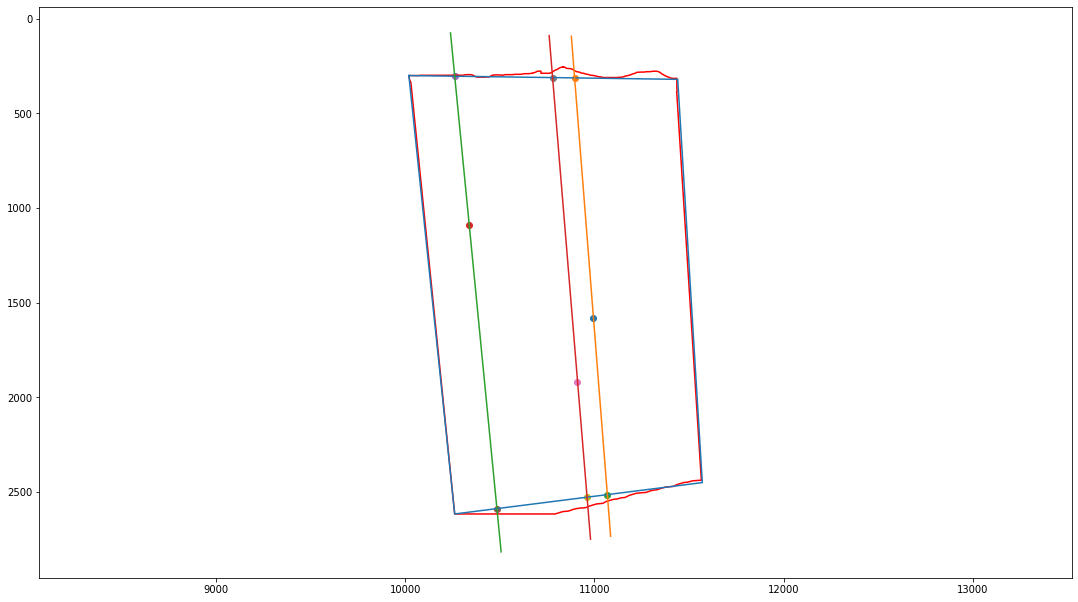

In [61]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.axis('equal')
plt.gca().invert_yaxis()
plt.plot(s1_coordinates[:,0], s1_coordinates[:,1], 'r')
plt.plot(quadrilateral[:,0], quadrilateral[:,1])

fractions = []
index_error_points = []
notImplementedError_points = []
for x, y in zip(cells_centroid_x[:3], cells_centroid_y[:3]):
    
#cell_coor = np.array([10776,  1261]) # Random
    cell_coor = np.array([x, y])
    try:
        vertical_line, top_point, bottom_point = get_vertical_line(cell_coor, quadrilateral)
        vertical_line = getExtrapoledLine(np.array(vertical_line)[0], np.array(vertical_line)[1])
        polygon = Polygon(quadrilateral)
        foo_line = np.array(vertical_line)
        plt.plot([foo_line[0][0], foo_line[1][0]],[foo_line[0][1], foo_line[1][1]])

        plt.scatter(cell_coor[0], cell_coor[1])
        plt.scatter(top_point[0], top_point[1])
        plt.scatter(bottom_point[0], bottom_point[1])
    except IndexError:
        index_error_points.append(cell_coor)
        print('index_error')        

'''

    vertical_intersection_line = list(polygon.intersection(vertical_line).coords)
    #random_lines.append(vertical_intersection_line)
    try:
        top_percentage_coord = [vertical_intersection_line[0][0], vertical_intersection_line[0][1]]
        botton_percentage_coord = [vertical_intersection_line[1][0], vertical_intersection_line[1][1]]
    except IndexError:
        index_error_points.append(cell_coor)
        print('index_error')
except NotImplementedError:
    #notImplementedError_points.append(cell_coor)
    print(NotImplementedError)
#fractions.append(get_depth(s1_coordinates,  np.array([x, y ]), slope))
'''



'\nfor point in notImplementedError_points:\n    plt.scatter(point[0], point[1], s=30)\nfor i, txt in enumerate(notImplementedError_points):\n    plt.annotate(str(notImplementedError_points[i]), (notImplementedError_points[i][0], notImplementedError_points[i][1]))\n'

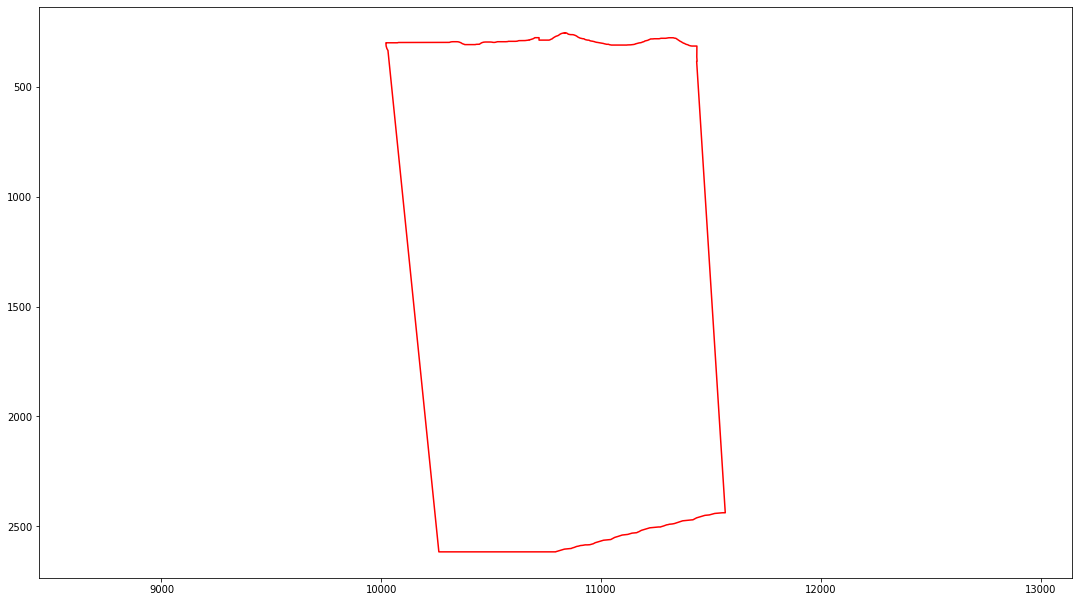

In [59]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.axis('equal')
plt.gca().invert_yaxis()
plt.plot(s1_coordinates[:,0], s1_coordinates[:,1], 'r')


#plt.scatter(bottom_left[0], bottom_left[1], s=50)
#plt.scatter(top_left[0], top_left[1], s=50)
#plt.scatter(top_right[0], top_right[1], s=50)
#plt.scatter(bottom_right[0], bottom_right[1], s=50)
#plt.scatter(top_percentage_coord[0], top_percentage_coord[1], s=30)
#plt.scatter(botton_percentage_coord[0], botton_percentage_coord[1], s=30)
'''
for point in notImplementedError_points:
    plt.scatter(point[0], point[1], s=30)
for i, txt in enumerate(notImplementedError_points):
    plt.annotate(str(notImplementedError_points[i]), (notImplementedError_points[i][0], notImplementedError_points[i][1]))
'''
#plt.scatter(intersection_line[0][0], intersection_line[0][1], s=30)
#plt.scatter(intersection_line[1][0], intersection_line[1][1], s=30)
#plt.plot([top_percentage_coord[0], botton_percentage_coord[0]],[top_percentage_coord[1], botton_percentage_coord[1]])
#plt.plot([vertical_intersection_line[0][0], vertical_intersection_line[1][0]],[vertical_intersection_line[0][1], vertical_intersection_line[1][1]])

In [9]:
quadrilateral

array([[10020.     ,   300.     ],
       [11440.     ,   320.     ],
       [11570.     ,  2450.     ],
       [10261.95864,  2615.76   ],
       [10020.     ,   300.     ]])

In [15]:
print(np.array(vertical_line)[0])

[10779.13366719   310.69202348]
